# Analysis of the [Student Depression Dataset](https://www.kaggle.com/datasets/hopesb/student-depression-dataset/data?select=Student+Depression+Dataset.csv)

This notebook aims to demonstrate the creation of a Data Science project using the Student Depression dataset to:
- Explore and understand the data.
- Perform necessary cleaning and transformations.
- Train and evaluate predictive models.

The Student Depression Dataset contains data from India on depression among students of different educational levels, and includes information on family history, workload, hours of sleep, and the student's diet.

## Importing Libraries

In [425]:
# Importing pandas for data manipulation and reading
import pandas as pd

import numpy as np

# Importing seaborn and matplotlib for creating graphs and visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Importing statsmodels for statistical modeling (e.g., logistic regression)
# and the stepwise module from the statstests package for variable selection via the stepwise procedure
import statsmodels.api as sm
from statstests.process import stepwise

# Importing functions from scikit-learn for:
# - Evaluation metrics (confusion matrix, accuracy, recall, etc.)
# - Splitting data into training and test sets
# - Modeling with decision trees and tree visualization
from sklearn.metrics import (confusion_matrix, accuracy_score, ConfusionMatrixDisplay,
                             recall_score, roc_curve, auc, roc_auc_score,
                             balanced_accuracy_score, mean_squared_error)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

# Configuring pandas to display all rows of the DataFrame during exploratory analysis
pd.set_option("display.max_rows", None)

## Cleaner and Exploration

### Data Loading:

In [426]:
dataset_path = '../data/Student Depression Dataset.csv'  # File path
main = pd.read_csv(dataset_path)  # Read CSV file

### Exploration

In [427]:
print(main.shape, '\n')  # Show the shape of the dataset
main.head()  # Display the first rows of the dataset

(27901, 18) 



,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [428]:
main.info()  # Displays information about the dataset columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [429]:
main.drop(columns=['id'], inplace=True)  # Removing the 'id' column

In [430]:
# Checking for null and NaN values
print(f'Null values:\n{main.isnull().sum()}\n')
print(f'NaN values:\n{main.isna().sum()}\n')

Null values:
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64

NaN values:
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure  

In [431]:
# Removing null and NaN values
main.dropna(inplace=True)

In [432]:
# Renaming columns
main.rename(columns={
    'Academic Pressure': 'AP',
    'Work Pressure': 'WP',
    'Study Satisfaction': 'SS',
    'Job Satisfaction': 'JS',
    'Sleep Duration': 'SD',
    'Dietary Habits': 'DH',
    'Have you ever had suicidal thoughts ?': 'ST',
    'Work/Study Hours': 'WSH',
    'Financial Stress': 'FS',
    'Family History of Mental Illness': 'FHMI'
}, inplace=True)

In [433]:
# Selecting columns of type object
columns_object = main.select_dtypes(include=['object']).columns.tolist()

# Selecting columns of type number (excluding the target variable 'Depression')
columns_numeric = main.drop(columns=['Depression']).select_dtypes(
    include=['number']).columns.tolist()

# Displaying column names
print('Feature columns:\n')
print(f"Object Columns: {columns_object} Count: {len(columns_object)}\n")
print(f"Numeric Columns: {columns_numeric} Count: {len(columns_numeric)}")

Feature columns:

Object Columns: ['Gender', 'City', 'Profession', 'SD', 'DH', 'Degree', 'ST', 'FHMI'] Count: 8

Numeric Columns: ['Age', 'AP', 'WP', 'CGPA', 'SS', 'JS', 'WSH', 'FS'] Count: 8


In [434]:
# Creating a copy of the dataset
df = main.copy()

### Numeric variables

In [435]:
# Function to check for outliers
def check_outliers(df):
    Q1 = df.quantile(q=.25)
    Q3 = df.quantile(q=.75)

    IQR = Q3 - Q1  # Calculating the interquartile range (IQR)
    limit_lower = Q1 - 1.5 * IQR
    limit_upper = Q3 + 1.5 * IQR

    outliers_upper = df[(df > limit_upper)].sort_values().values
    outliers_lower = df[(df < limit_lower)].sort_values().values

    print(f'🔼 Upper Outliers: {outliers_upper}')
    print(f'🔽 Lower Outliers: {outliers_lower}')

    plt.figure(figsize=(8, 8))
    sns.boxplot(df)
    plt.show()

    return limit_lower, limit_upper

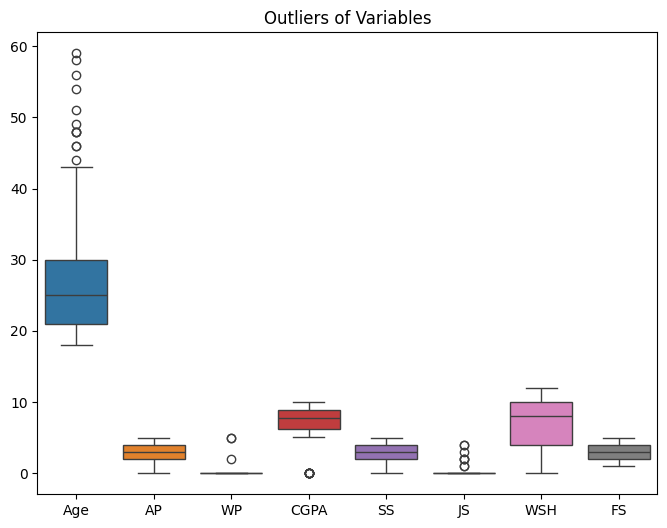

In [436]:
# Visualizing outliers in numeric variables
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[columns_numeric])
plt.title('Outliers of Variables')
plt.show()

#### Age

🔼 Upper Outliers: [44. 46. 46. 48. 48. 48. 49. 51. 54. 56. 58. 59.]
🔽 Lower Outliers: []


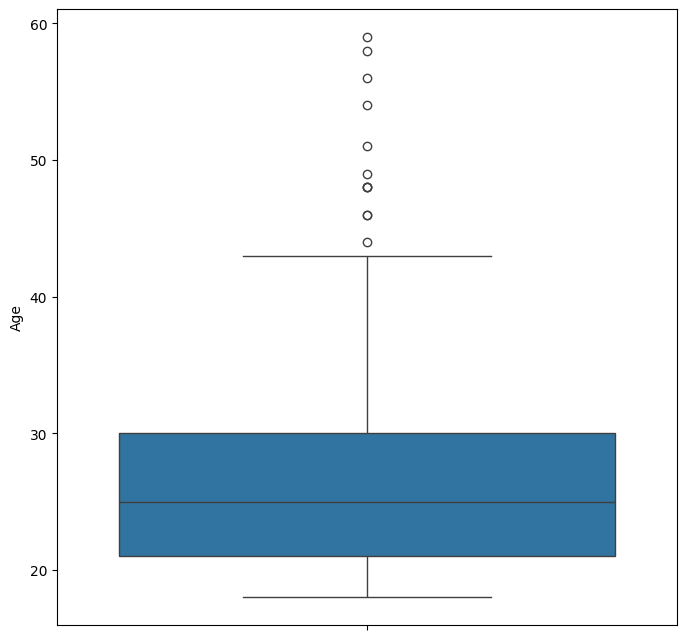

In [437]:
# Checking outliers for the 'Age' column
limit_lower, limit_upper = check_outliers(df['Age'])

In [438]:
# Removing age outliers
df.query('Age < @limit_upper', inplace=True)

#### WP (Work Pressure)

🔼 Upper Outliers: [2. 5. 5.]
🔽 Lower Outliers: []


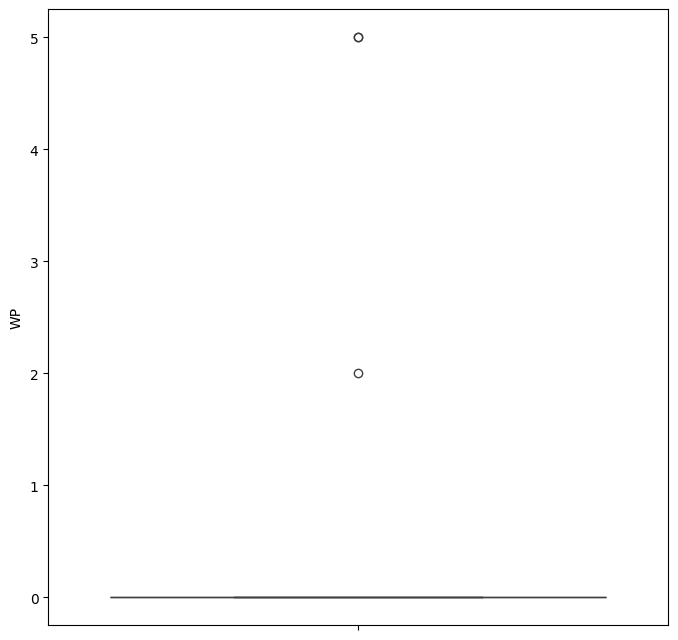

In [439]:
# Checking outliers for the 'WP' (Work Pressure) column
limit_lower, limit_upper = check_outliers(df['WP'])

In [440]:
# Checking the value counts of the 'WP' column, normalized to show the proportion of each value
df['WP'].value_counts(normalize=True)

WP
0.0    0.999892
5.0    0.000072
2.0    0.000036
Name: proportion, dtype: float64

In [441]:
# Removing the 'WP' variable due to it containing almost only 0 values
df.drop(columns=["WP"], inplace=True)

#### CGPA (Cumulative Grade Point Average)

🔼 Upper Outliers: []
🔽 Lower Outliers: [0. 0. 0. 0. 0. 0. 0. 0. 0.]


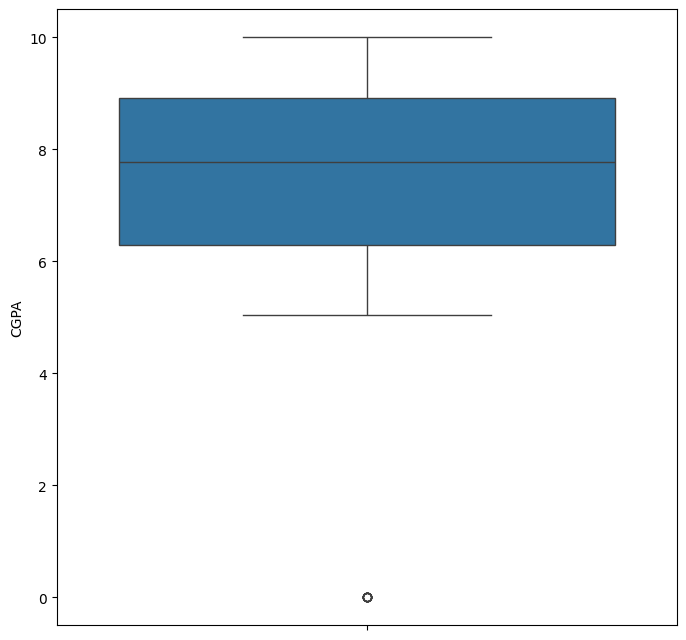

In [442]:
# Checking outliers for the 'CGPA' (Cumulative Grade Point Average) column
limit_lower, limit_upper = check_outliers(df['CGPA'])

In [443]:
# Removing outliers from the 'CGPA' column
df.query('CGPA > @limit_lower', inplace=True)

#### JS (Job Satisfaction)

🔼 Upper Outliers: [2. 3.]
🔽 Lower Outliers: []


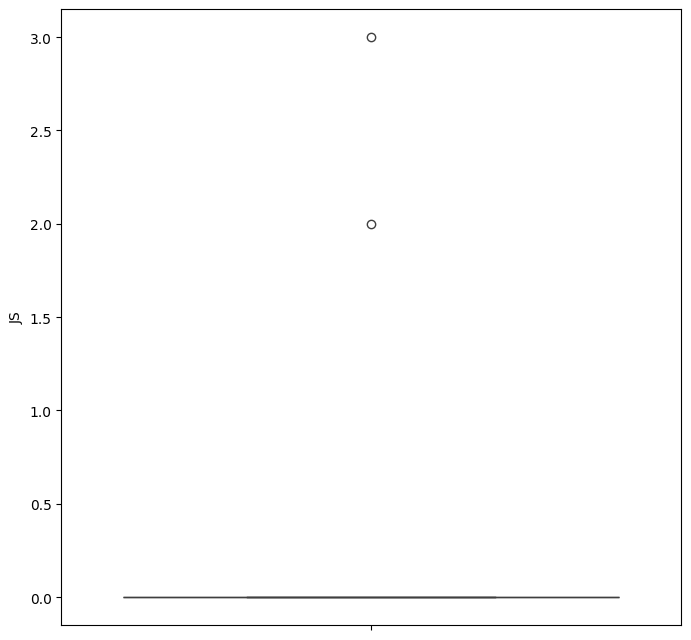

In [444]:
# Checking outliers for the 'JS' (Job Satisfaction) column
limit_lower, limit_upper = check_outliers(df['JS'])

In [445]:
# Checking the value counts of the 'WP' column, normalized to show the proportion of each value
df['JS'].value_counts(normalize=True)

JS
0.0    0.999928
3.0    0.000036
2.0    0.000036
Name: proportion, dtype: float64

In [446]:
# Removing the 'JS' variable due to it containing almost only 0 values
df.drop(columns=["JS"], inplace=True)

<Axes: >

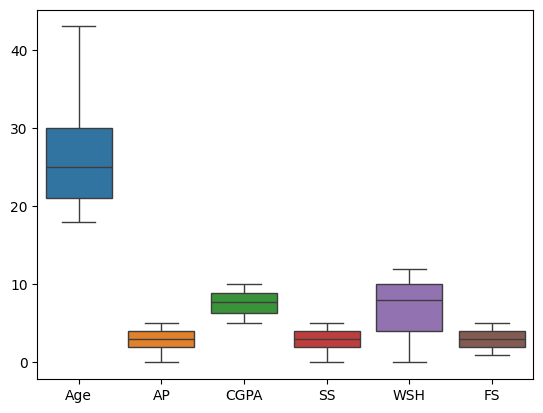

In [447]:
# Validating all numeric variables after outlier correction.
columns_numeric = df.drop(columns=['Depression']).select_dtypes(
    include=['number']).columns.tolist()
sns.boxplot(data=df[columns_numeric])

### Categorical Variables

In [448]:
# Function to plot a pie chart
def pie_plot(data, labels, title):
    plt.figure(figsize=(6, 6))
    plt.pie(data, labels=labels, autopct='%1.1f%%')
    plt.title(title)
    plt.show()

#### Gender

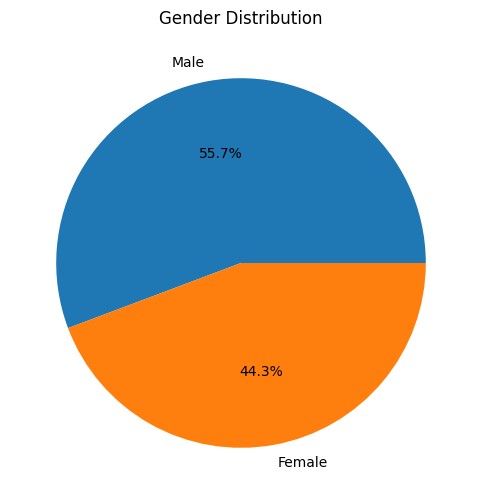

In [449]:
# Plotting the gender distribution using a pie chart
gender_counts = df['Gender'].value_counts()
pie_plot(data=gender_counts, labels=gender_counts.index,
         title='Gender Distribution')

In [450]:
# Converting 'Gender' column to dummy variable
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

#### City

In [451]:
# Checking the value counts of the 'City' column
df['City'].value_counts()

City
Kalyan                1570
Srinagar              1371
Hyderabad             1339
Vasai-Virar           1290
Lucknow               1153
Thane                 1139
Ludhiana              1110
Agra                  1093
Surat                 1077
Kolkata               1065
Jaipur                1036
Patna                 1007
Visakhapatnam          969
Pune                   967
Ahmedabad              949
Bhopal                 933
Chennai                883
Meerut                 824
Rajkot                 814
Delhi                  768
Bangalore              767
Ghaziabad              744
Mumbai                 699
Vadodara               692
Varanasi               684
Nagpur                 650
Indore                 643
Kanpur                 609
Nashik                 545
Faridabad              461
Saanvi                   2
Bhavna                   2
City                     2
Harsha                   2
Less Delhi               1
M.Tech                   1
3.0                    

In [452]:
# Filtering cities that have more than 2 occurrences
filtered_cities = df['City'].value_counts()[lambda x: x > 2].index
print(filtered_cities)

# Keeping only the rows where the 'City' is in the filtered list
df.query('City in @filtered_cities', inplace=True)

Index(['Kalyan', 'Srinagar', 'Hyderabad', 'Vasai-Virar', 'Lucknow', 'Thane',
       'Ludhiana', 'Agra', 'Surat', 'Kolkata', 'Jaipur', 'Patna',
       'Visakhapatnam', 'Pune', 'Ahmedabad', 'Bhopal', 'Chennai', 'Meerut',
       'Rajkot', 'Delhi', 'Bangalore', 'Ghaziabad', 'Mumbai', 'Vadodara',
       'Varanasi', 'Nagpur', 'Indore', 'Kanpur', 'Nashik', 'Faridabad'],
      dtype='object', name='City')


In [453]:
# Creating a new column 'State' based on the 'City' column using a predefined mapping
city_to_state = {
    'Visakhapatnam': 'Andhra_Pradesh',
    'Bangalore': 'Karnataka',
    'Srinagar': 'Jammu_and_Kashmir',
    'Varanasi': 'Uttar_Pradesh',
    'Jaipur': 'Rajasthan',
    'Pune': 'Maharashtra',
    'Thane': 'Maharashtra',
    'Chennai': 'Tamil_Nadu',
    'Nagpur': 'Maharashtra',
    'Nashik': 'Maharashtra',
    'Vadodara': 'Gujarat',
    'Kalyan': 'Maharashtra',
    'Rajkot': 'Gujarat',
    'Ahmedabad': 'Gujarat',
    'Kolkata': 'West_Bengal',
    'Mumbai': 'Maharashtra',
    'Lucknow': 'Uttar_Pradesh',
    'Indore': 'Madhya_Pradesh',
    'Surat': 'Gujarat',
    'Ludhiana': 'Punjab',
    'Bhopal': 'Madhya_Pradesh',
    'Meerut': 'Uttar_Pradesh',
    'Agra': 'Uttar_Pradesh',
    'Ghaziabad': 'Uttar_Pradesh',
    'Hyderabad': 'Telangana',
    'Vasai-Virar': 'Maharashtra',
    'Kanpur': 'Uttar_Pradesh',
    'Patna': 'Bihar',
    'Faridabad': 'Haryana',
    'Delhi': 'Delhi'
}

# Mapping the cities to states
df['State'] = df['City'].map(city_to_state)

#### State

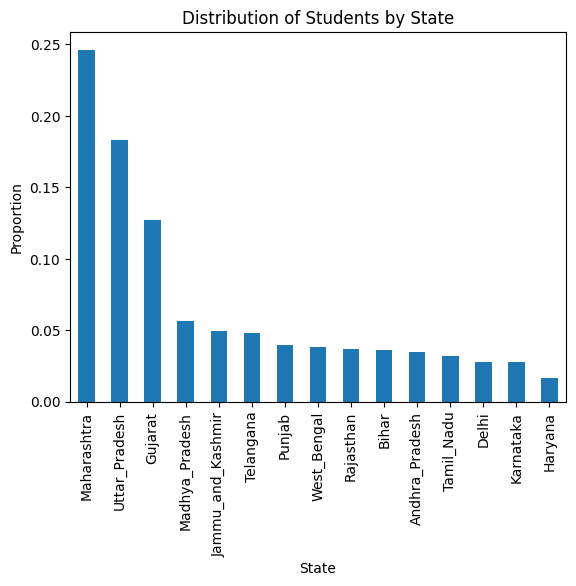

In [454]:
# Plotting the normalized value counts of the 'State' column as a bar chart
df['State'].value_counts(normalize=True).plot.bar()
plt.title('Distribution of Students by State')
plt.ylabel('Proportion')
plt.xlabel('State')
plt.show()

In [455]:
# Removing the 'City' column and creating dummy variables for 'State'
dummies = pd.get_dummies(df['State'], dtype=int)
df = pd.concat([df, dummies], axis=1)

# Dropping the 'City' and 'State' columns
df.drop(columns=['City', 'State'], inplace=True)

#### Profession

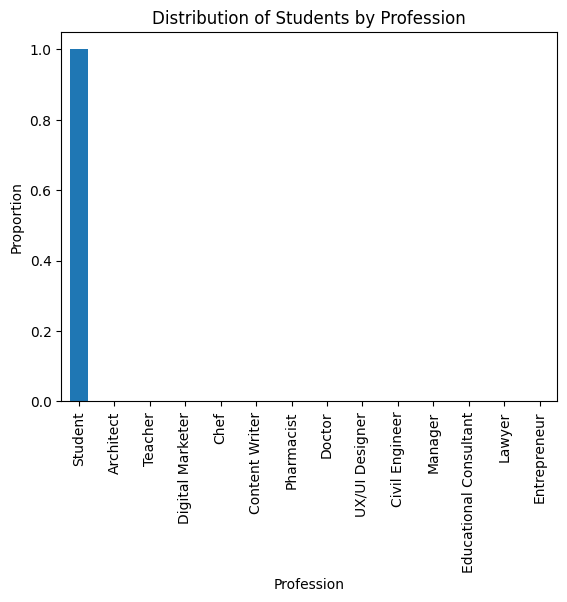

In [456]:
# Plotting the normalized value counts of the 'Profession' column as a bar chart
df['Profession'].value_counts(normalize=True).plot.bar()
plt.title('Distribution of Students by Profession')
plt.ylabel('Proportion')
plt.xlabel('Profession')
plt.show()

In [457]:
# Filtering the dataset to keep only the rows where 'Profession' is 'Student'
df.query('Profession == "Student"', inplace=True)

In [458]:
# Dropping the 'Profession' column as it is no longer needed
df.drop(columns=['Profession'], inplace=True)

#### SD (Sleep Duration)

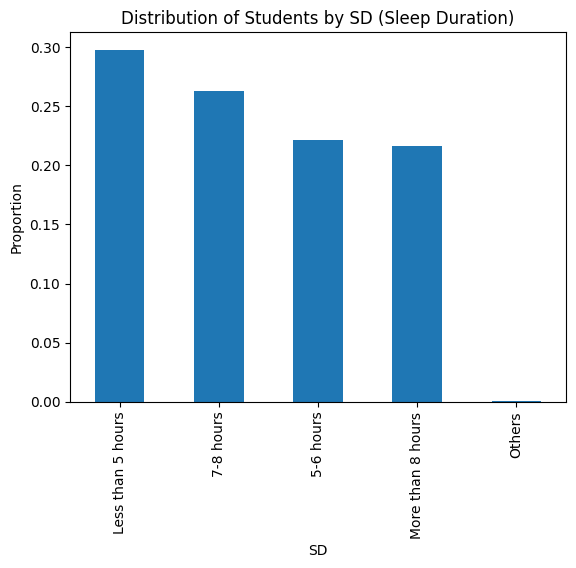

In [459]:
# Plotting the normalized value counts of the 'SD' column as a bar chart
df['SD'].value_counts(normalize=True).plot.bar()
plt.title('Distribution of Students by SD (Sleep Duration)')
plt.ylabel('Proportion')
plt.xlabel('SD')
plt.show()

In [460]:
# Removing the 'Others' category from the 'SD' (Sleep Duration) column due to its low significance for the model
df.query('SD != "Others"', inplace=True)

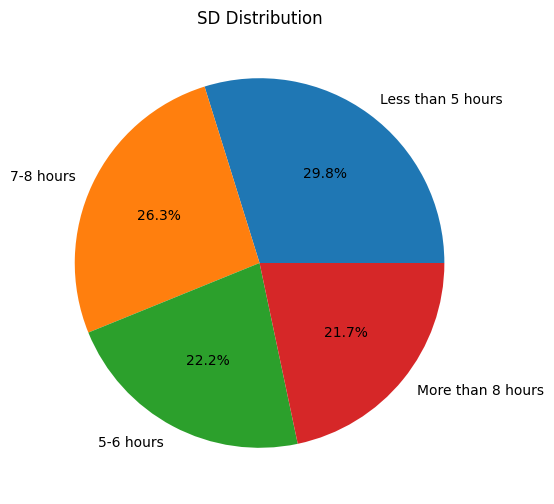

In [461]:
# Plotting the distribution of 'SD' (Sleep Duration) using a pie chart
sd_counts = df['SD'].value_counts()
pie_plot(data=sd_counts, labels=sd_counts.index,
         title='SD Distribution')

In [462]:
# Renaming the 'SD' (Sleep Duration) variable values for compatibility with statsmodels
rename_sd_variable = {
    'Less than 5 hours': 'less_than_five_hours',
    '7-8 hours': 'seven_eight_hours',
    '5-6 hours': 'five_six_hours',
    'More than 8 hours': 'more_than_eight_five_six_hours'}

df['SD'] = df['SD'].map(rename_sd_variable)

In [463]:
# Creating dummy variables for the 'SD' (Sleep Duration) column
dummies = pd.get_dummies(df['SD'], dtype=int)
df = pd.concat([df, dummies], axis=1)

# Dropping the original 'SD' column
df.drop(columns=['SD'], inplace=True)

#### DH (Dietary Habits)

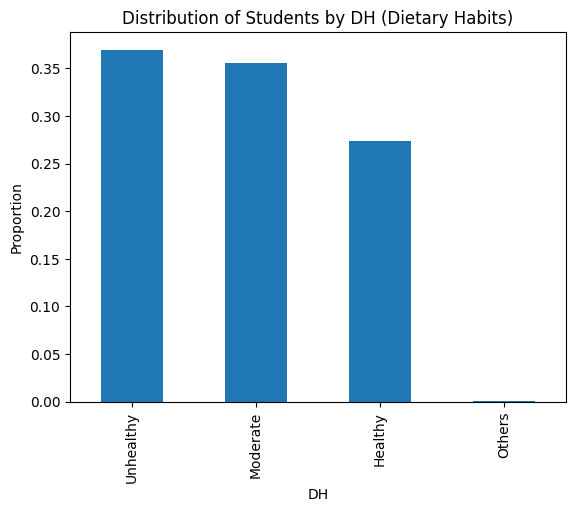

In [464]:
# Plotting the normalized value counts of the 'DH' column as a bar chart
df['DH'].value_counts(normalize=True).plot.bar()
plt.title('Distribution of Students by DH (Dietary Habits)')
plt.ylabel('Proportion')
plt.xlabel('DH')
plt.show()

In [465]:
# Removing the 'Others' category from the 'DH' (Dietary Habits) column due to its low significance for the model
df.query('DH != "Others"', inplace=True)

In [466]:
# Creating dummy variables for the 'DH' (Dietary Habits) column
dummies = pd.get_dummies(df['DH'], dtype=int)
df = pd.concat([df, dummies], axis=1)

# Dropping the original 'DH' column
df.drop(columns=['DH'], inplace=True)

#### Degree

In [467]:
# Checking the value counts of the 'Degree' column
df['Degree'].value_counts()

Degree
Class 12    6064
B.Ed        1857
B.Com       1503
B.Arch      1475
BCA         1428
MSc         1183
B.Tech      1151
MCA         1038
M.Tech      1019
BHM          921
BSc          881
M.Ed         816
B.Pharm      808
M.Com        733
BBA          694
MBBS         692
LLB          668
BE           608
BA           594
M.Pharm      580
MD           567
MBA          560
MA           542
PhD          517
LLM          480
MHM          191
ME           185
Others        35
Name: count, dtype: int64

In [468]:
# Removing the 'Others' category from the 'Degree' column due to its low significance for the model
df.query('Degree != "Others"', inplace=True)

In [469]:
# Mapping the 'Degree' column to more meaningful categories
def categorize_education(degree):
    if degree == "Class 12":
        return 'secondary_education'
    elif degree in ["PhD", "MSc", "MHM", "ME", "MD", "MCA", "MBBS", "MBA", "MA",
                    "M.Tech", "M.Pharm", "M.Ed", "M.Com", "LLM"]:
        return 'postgraduate_degree'
    elif degree in ["LLB", "BSc", "BHM", "BE", "BCA", "BBA", "BA", "B.Tech",
                    "B.Pharm", "B.Ed", "B.Com", "B.Arch"]:
        return 'undergraduate_degree'


# Applying the categorization function to the 'Degree' column
df["Degree"] = df["Degree"].apply(categorize_education).astype('object')

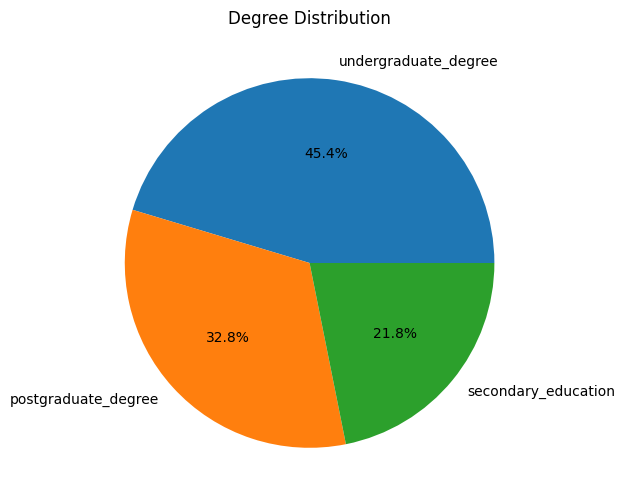

In [470]:
# Plotting the distribution of 'Degree' using a pie chart
degree_counts = df['Degree'].value_counts()
pie_plot(data=degree_counts, labels=degree_counts.index,
         title='Degree Distribution')

In [471]:
# Creating dummy variables for the 'Degree' column
dummies = pd.get_dummies(df['Degre(Suicidal Thoughts) e'], dtype=int)
df = pd.concat([df, dummies], axis=1)

# Dropping the original 'Degree' column
df.drop(columns=['Degree'], inplace=True)

KeyError: 'Degre(Suicidal Thoughts) e'

#### ST (Suicidal Thoughts)

In [ ]:
# Checking the normalized value counts of the 'ST' (Suicidal Thoughts) column
df['ST'].value_counts(normalize=True)

ST
Yes    0.632787
No     0.367213
Name: proportion, dtype: float64

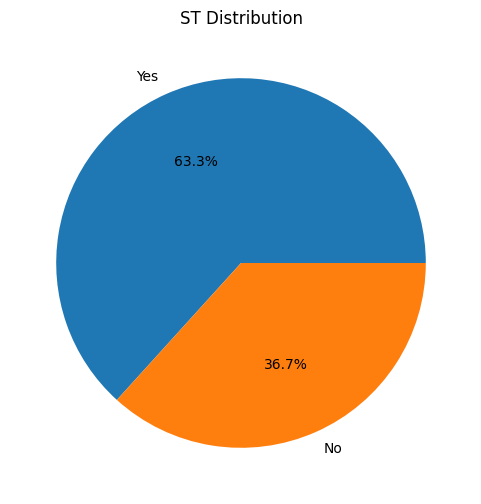

In [ ]:
# Plotting the distribution of 'ST' (Suicidal Thoughts) using a pie chart
st_counts = df['ST'].value_counts()
pie_plot(data=st_counts, labels=st_counts.index,
         title='ST Distribution')

In [ ]:
# Mapping the 'ST' (Suicidal Thoughts) column to binary values
df['ST'] = df['ST'].map({'No': 0, 'Yes': 1})

#### FHMI (Family History of Mental Illness)

In [ ]:
# Checking the normalized value counts of the 'FHMI' (Family History of Mental Illness) column
df['FHMI'].value_counts(normalize=True)

FHMI
No     0.515871
Yes    0.484129
Name: proportion, dtype: float64

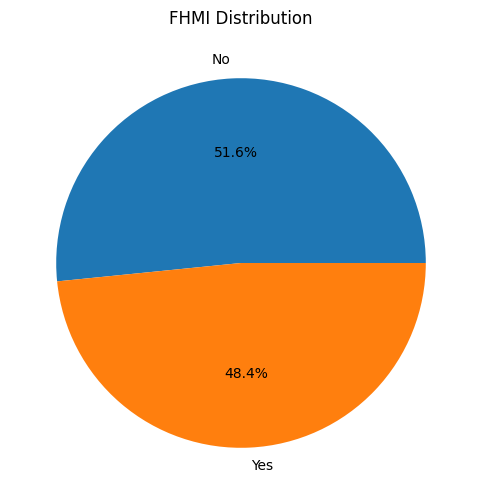

In [ ]:
# Plotting the distribution of 'FHMI' (Family History of Mental Illness) using a pie chart
fhmi_counts = df['FHMI'].value_counts()
pie_plot(data=fhmi_counts, labels=fhmi_counts.index,
         title='FHMI Distribution')

In [ ]:
# Mapping the 'FHMI' (Family History of Mental Illness) column to binary values
df['FHMI'] = df['FHMI'].map({'No': 0, 'Yes': 1})

### Validating the Dataset after Cleaning and Data Modifications

In [ ]:
# Printing the shape of the dataset (rows and columns)
print(df.shape)
# Displaying the first few rows of the dataset
display(df.head())
# Displaying the general information of the dataset (data types, non-null counts, etc.)
df.info()

(27755, 33)


,Gender,Age,AP,CGPA,SS,Degree,ST,WSH,FS,FHMI,...,Telangana,Uttar_Pradesh,West_Bengal,five_six_hours,less_than_five_hours,more_than_eight_five_six_hours,seven_eight_hours,Healthy,Moderate,Unhealthy
0,0,33.0,5.0,8.97,2.0,undergraduate_degree,Yes,3.0,1.0,No,...,0,0,0,1,0,0,0,1,0,0
1,1,24.0,2.0,5.90,5.0,undergraduate_degree,No,3.0,2.0,Yes,...,0,0,0,1,0,0,0,0,1,0
2,0,31.0,3.0,7.03,5.0,undergraduate_degree,No,9.0,1.0,Yes,...,0,0,0,0,1,0,0,1,0,0
3,1,28.0,3.0,5.59,2.0,undergraduate_degree,Yes,4.0,5.0,Yes,...,0,1,0,0,0,0,1,0,1,0
4,1,25.0,4.0,8.13,3.0,postgraduate_degree,Yes,1.0,1.0,No,...,0,0,0,1,0,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
Index: 27755 entries, 0 to 27900
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          27755 non-null  int64  
 1   Age                             27755 non-null  float64
 2   AP                              27755 non-null  float64
 3   CGPA                            27755 non-null  float64
 4   SS                              27755 non-null  float64
 5   Degree                          27755 non-null  object 
 6   ST                              27755 non-null  object 
 7   WSH                             27755 non-null  float64
 8   FS                              27755 non-null  float64
 9   FHMI                            27755 non-null  object 
 10  Depression                      27755 non-null  int64  
 11  Andhra_Pradesh                  27755 non-null  int64  
 12  Bihar                           27755

In [ ]:
# Saving the cleaned and modified dataset to a parquet file
df.to_parquet('../data/Student Depression Dataset Treat.parquet')

## Modeling and Training

In [ ]:
df_models_result = pd.DataFrame()  # DataFrame to save the results of models

def models_statistics(model_name, observed, predicted, regression=False):

    # Convert any input to a numpy array
    values = np.array(predicted)

    # If it's a regression task, convert the output to binary based on a cutoff
    if regression:
        cut_off = 0.5
        values = np.where(values > cut_off, 1, 0)  # Convert to binary (0 or 1)

    # Confusion Matrix Calculation
    cm = confusion_matrix(observed, values)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()  # Invert X-axis to show the correct format
    plt.gca().invert_yaxis()  # Invert Y-axis to show the correct format
    plt.show()

    # Calculating performance metrics
    sensitivity = recall_score(observed, values, pos_label=1)  # True Positive Rate
    specificity = recall_score(observed, values, pos_label=0)  # True Negative Rate
    accuracy = accuracy_score(observed, values)  # Overall accuracy
    balanced_accuracy = balanced_accuracy_score(observed, values)  # Accuracy for imbalanced data
    mse = mean_squared_error(observed, values)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error

    # Creating a DataFrame to store performance indicators
    indicators = pd.DataFrame({
        'Model_Name': [model_name],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'Accuracy': [accuracy],
        'Balanced_Accuracy': [balanced_accuracy],
        'MSE': [mse],
        'RMSE': [rmse]
    })

    # ROC Curve Calculation
    fpr, tpr, _ = roc_curve(observed, values)
    roc_auc = auc(fpr, tpr)  # Area Under the Curve (AUC)
    gini = (roc_auc - 0.5) / 0.5  # Gini Coefficient

    # Plotting the ROC Curve
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, marker='o', color='darkorchid',
             markersize=10, linewidth=3)  # ROC curve
    plt.plot(fpr, fpr, color='gray', linestyle='dashed')  # Diagonal line (no discrimination)
    plt.title(
        f'Area Under the Curve: {round(roc_auc, 4)} | Gini Coefficient: {round(gini, 4)}', fontsize=22)
    plt.xlabel('1 - Specificity', fontsize=20)
    plt.ylabel('Sensitivity', fontsize=20)
    plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
    plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
    plt.show()

    # Printing the performance indicators
    print(indicators.T)

    return indicators

### Logistic Regression

#### Creating the formula to run the logistic regression model with statsmodels

In [472]:
# Renaming columns by replacing spaces or hyphens with underscores to make them compatible with formula syntax
df.columns = df.columns.str.replace(r'\s|-', '_', regex=True)

# Creating a list of all columns, excluding 'Depression', which will be the target variable
list_colums_dummies = list(df.drop(columns=['Depression']).columns)

# Joining all column names with ' + ' to create the formula for logistic regression
formula_dummies_model = ' + '.join(list_colums_dummies)

# Adding the target variable 'Depression' at the beginning of the formula to complete the logistic regression formula
formula_dummies_model = 'Depression ~ ' + formula_dummies_model

# Displaying the final formula
formula_dummies_model

'Depression ~ Gender + Age + AP + CGPA + SS + Degree + ST + WSH + FS + FHMI + Andhra_Pradesh + Bihar + Delhi + Gujarat + Haryana + Jammu_and_Kashmir + Karnataka + Madhya_Pradesh + Maharashtra + Punjab + Rajasthan + Tamil_Nadu + Telangana + Uttar_Pradesh + West_Bengal + five_six_hours + less_than_five_hours + more_than_eight_five_six_hours + seven_eight_hours + Healthy + Moderate + Unhealthy'

#### Training the model

In [473]:
model = sm.Logit.from_formula(formula_dummies_model, df).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.347921
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Depression   No. Observations:                27755
Model:                          Logit   Df Residuals:                    27724
Method:                           MLE   Df Model:                           30
Date:                ter, 25 fev 2025   Pseudo R-squ.:                  0.4872
Time:                        15:55:25   Log-Likelihood:                -9656.6
converged:                       True   LL-Null:                       -18831.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.8134        nan        nan        nan         nan         nan
Degree[T.secondary_education]     -0.1743      0.064     -2.725      0.006      -0.300      -0.049
Degree[T.undergraduate_degree]    -0.0145      0.042     -0.347      0.729      -0.096       0.067
ST[T.Yes]                          2.5150      0.039     64.025      0.000       2.438       2.592
FHMI[T.Yes]                        0.2440      0.037      6.673      0.000       0.172       0.316
Gender                             0.0082      0.037      0.223      0.824      -0.064       0.081
Age                               -0.1183      0.005    -24.353      0.000      -0.128      -0.109
AP                                 0.8388      0.015     56.042      0.000       0.809       0.868
CGPA                               0.0562      0.013      4.484      0.000       0.032       0.081
SS                                -0.2427      0.014    -17.782      0.000      -0.269      -0.216
WSH                                0.1176      0.005     23.538      0.000       0.108       0.127
FS                                 0.5532      0.013     41.298      0.000       0.527       0.579
Andhra_Pradesh                    -0.1374        nan        nan        nan         nan         nan
Bihar                              0.0438        nan        nan        nan         nan         nan
Delhi                             -0.0920        nan        nan        nan         nan         nan
Gujarat                           -0.0830        nan        nan        nan         nan         nan
Haryana                           -0.0316        nan        nan        nan         nan         nan
Jammu_and_Kashmir                 -0.2204        nan        nan        nan         nan         nan
Karnataka                         -0.0917        nan        nan        nan         nan         nan
Madhya_Pradesh                    -0.0778        nan        nan        nan         nan         nan
Maharashtra                       -0.2125        nan        nan        nan         nan         nan
Punjab                            -0.1068        nan        nan        nan         nan         nan
Rajasthan                         -0.4182        nan        nan        nan         nan         nan
Tamil_Nadu                        -0.2667        nan        nan        nan         nan         nan
Telangana                          0.1143        nan        nan        nan         nan         nan
Uttar_Pradesh                     -0.2477        nan        nan        nan         nan         nan
West_Bengal                        0.0143        nan        nan        nan         nan         nan
five_six_hours                    -0.4868        nan        nan        nan         nan         nan
less_than_five_hours              -0.1150        nan        nan        nan         nan         nan
more_than_eight_five_six_hours    -0.7408        nan        nan        na

#### Running the stepwise process for variable removal.

The stepwise process is a method used for selecting the most significant features in a model by adding or removing variables based on statistical criteria. This approach helps in improving the model’s performance and reducing overfitting by keeping only the most relevant predictors.

In [59]:
stepwise_model = stepwise(model, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 Depression ~ Q('Gender') + Q('Age') + Q('AP') + Q('CGPA') + Q('SS') + Q('ST') + Q('WSH') + Q('FS') + Q('FHMI') + Q('Andhra_Pradesh') + Q('Bihar') + Q('Delhi') + Q('Gujarat') + Q('Haryana') + Q('Jammu_and_Kashmir') + Q('Karnataka') + Q('Madhya_Pradesh') + Q('Maharashtra') + Q('Punjab') + Q('Rajasthan') + Q('Tamil_Nadu') + Q('Telangana') + Q('Uttar_Pradesh') + Q('West_Bengal') + Q('five_six_hours') + Q('less_than_five_hours') + Q('more_than_eight_five_six_hours') + Q('seven_eight_hours') + Q('Healthy') + Q('Moderate') + Q('Unhealthy') + Q('postgraduate_degree') + Q('secondary_education') + Q('undergraduate_degree')
Optimization terminated successfully.
         Current function value: 0.347921
         Iterations 7

 Discarding atribute "Q('Haryana')" with p-value equal to 0.9999999909806911 

Estimating model...: 
 Depression ~ Q('Gender') + Q('Age') + Q('AP') + Q('CGPA') + Q('SS') + Q('ST') + Q('WSH') + Q('FS') + Q('FHMI') + Q('Andhra_Pra

#### Analisando os resultados do modelo

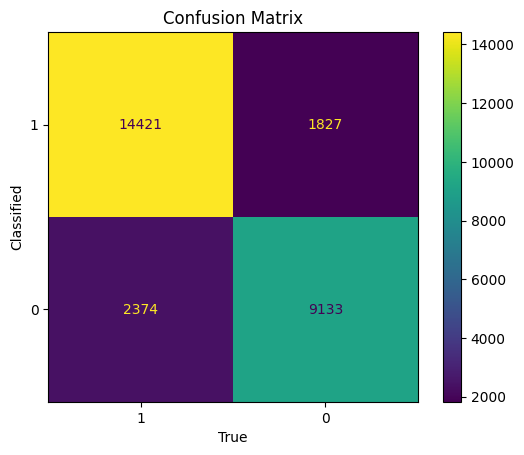

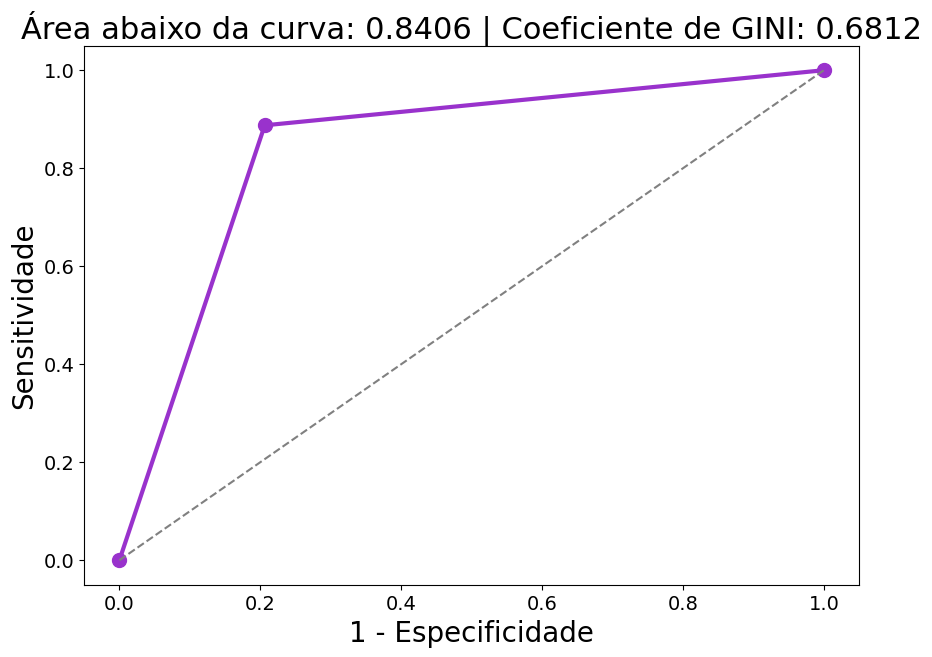

                                     0
Model_Name         regression logistic
Sensitivity                   0.887555
Specificity                   0.793691
Accuracy                       0.84864
Balanced_Accuracy             0.840623
MSE                            0.15136
RMSE                           0.38905


In [60]:
predict = stepwise_model.predict(df.drop(columns=["Depression"]))
model_indicators = models_statistics(model_name='regression logistic', observated=df['Depression'],
                                     predicts=predict, regression=True)

df_models_result = pd.concat(
    [df_models_result, model_indicators], ignore_index=True)

### Árvore de Decisão

#### Separando as variasveis preditoras da target

In [61]:
X = df.drop(columns=['Depression'])
y = df['Depression']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22204, 34)
(22204,)
(5551, 34)
(5551,)


In [62]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=3).fit(X_train, y_train)

In [63]:
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15],
    'criterion': ['gini', 'entropy']
}

grid_decision_tree = GridSearchCV(estimator=clf,
                                  param_grid=param_grid,
                                  cv=5,
                                  scoring='accuracy')

grid_decision_tree.fit(X_train, y_train)

print("Best Hyperparameters:", grid_decision_tree.best_params_)
print("Best Accuracy:", grid_decision_tree.best_score_)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
Best Accuracy: 0.8257523972970944


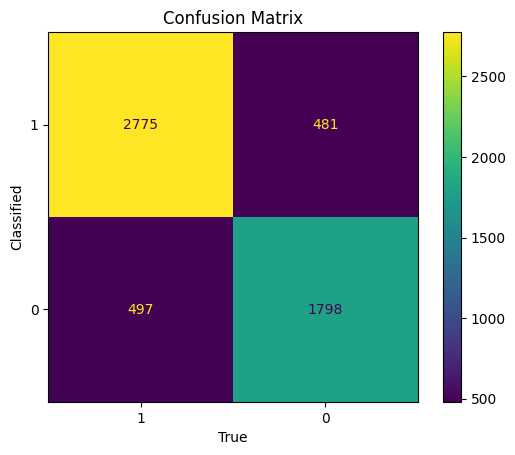

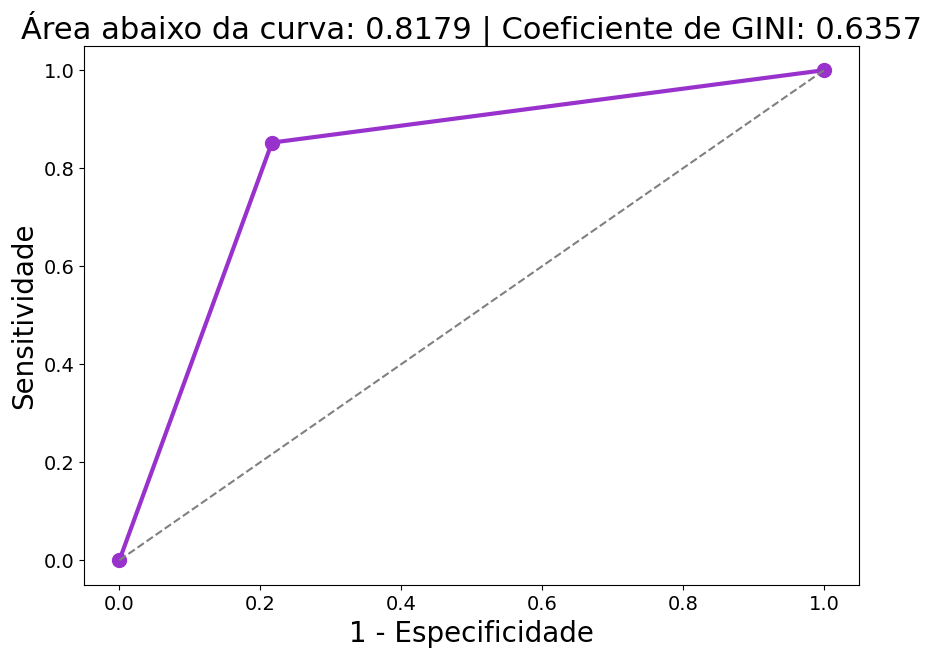

                                          0
Model_Name         decision tree classifier
Sensitivity                        0.852273
Specificity                        0.783442
Accuracy                           0.823816
Balanced_Accuracy                  0.817857
MSE                                0.176184
RMSE                               0.419743


In [64]:
clf = grid_decision_tree.best_estimator_
predict = clf.predict(X_test)

model_indicators = models_statistics(model_name='decision tree classifier',
                                     observated=y_test, predicts=predict)

df_models_result = pd.concat(
    [df_models_result, model_indicators], ignore_index=True)

In [65]:
param_grid = {'n_estimators': [100, 200],
              'max_depth': [2, 4, 8],
              'max_features': [5, 10, 15],
              'criterion': ['gini', 'entropy']
              }

grid_rf = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid=param_grid,
                       cv=5)

grid_rf.fit(X_train, y_train)

print("Best Hyperparameters:", grid_rf.best_params_)
print("Best Accuracy:", grid_rf.best_score_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 15, 'n_estimators': 200}
Best Accuracy: 0.8416504784451193


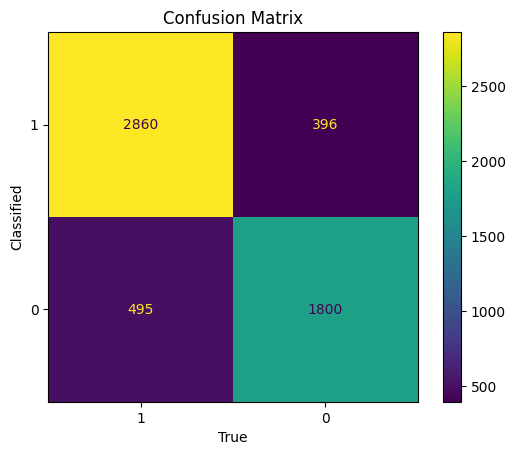

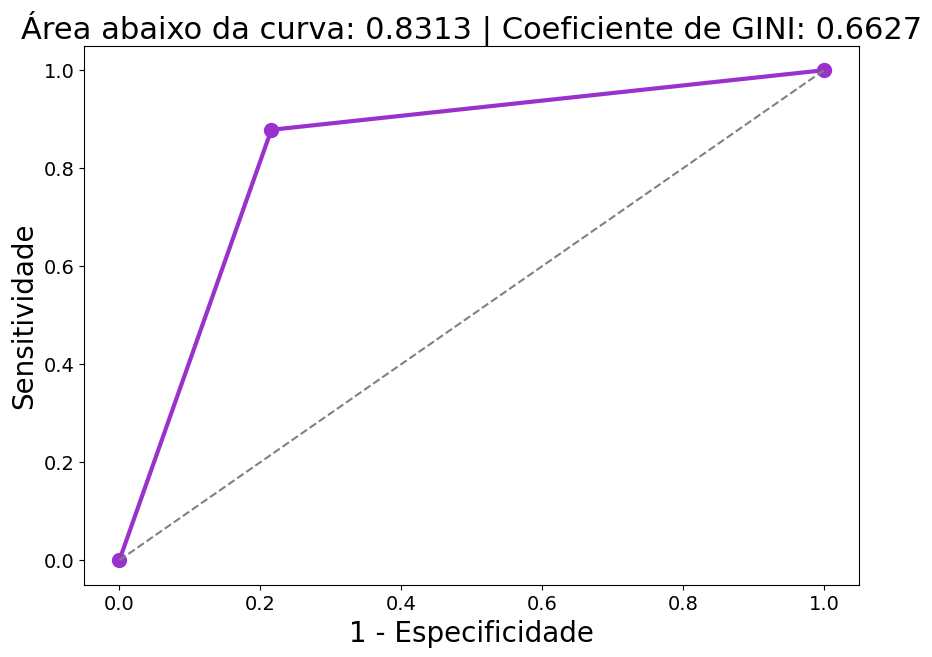

                                          0
Model_Name         random forest classifier
Sensitivity                        0.878378
Specificity                        0.784314
Accuracy                           0.839488
Balanced_Accuracy                  0.831346
MSE                                0.160512
RMSE                               0.400639


In [66]:
rf = grid_rf.best_estimator_
predict = rf.predict(X_test)
model_indicators = models_statistics(model_name='random forest classifier',
                                     observated=y_test, predicts=predict)

df_models_result = pd.concat(
    [df_models_result, model_indicators], ignore_index=True)

In [67]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3],
    'gamma': [0],
    'learning_rate': [0.1, 0.4],
    'colsample_bytree': [0.6, 0.8],
    'min_child_weight': [1],
    'subsample': [0.75, 1]
}

grid_search_xgb = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic'), param_grid=param_grid,
                               scoring='roc_auc', cv=10, verbose=0, n_jobs=-1).fit(X_train, y_train)

print("Best Hyperparameters:", grid_search_xgb.best_params_)
print("Best Accuracy:", np.round(grid_search_xgb.best_score_, 4))

Best Hyperparameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 1}
Best Accuracy: 0.9219


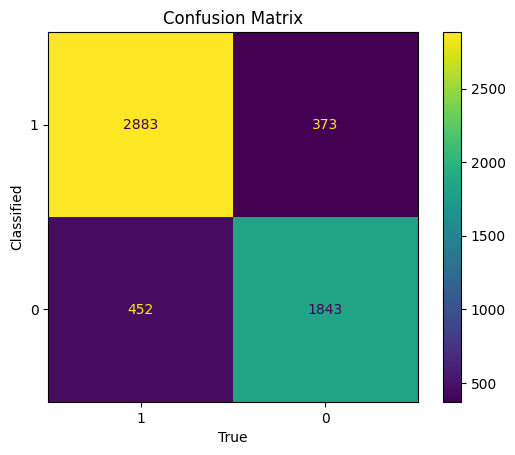

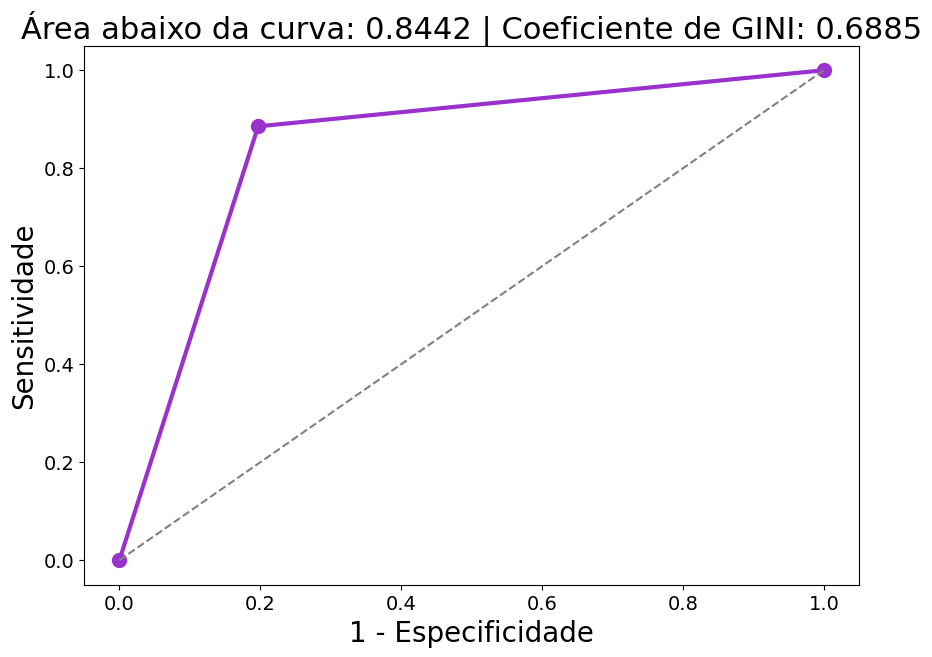

                               0
Model_Name         xgbclassifier
Sensitivity             0.885442
Specificity              0.80305
Accuracy                0.851378
Balanced_Accuracy       0.844246
MSE                     0.148622
RMSE                    0.385515


In [68]:
xgb = grid_search_xgb.best_estimator_

predict = xgb.predict(X_test)
model_indicators = models_statistics(model_name='xgbclassifier',
                                     observated=y_test, predicts=predict)

df_models_result = pd.concat(
    [df_models_result, model_indicators], ignore_index=True)

## Resultados

In [69]:
df_models_result.sort_values(by="Balanced_Accuracy", ascending=False)

,Model_Name,Sensitivity,Specificity,Accuracy,Balanced_Accuracy,MSE,RMSE
3,xgbclassifier,0.885442,0.803050,0.851378,0.844246,0.148622,0.385515
0,regression logistic,0.887555,0.793691,0.848640,0.840623,0.151360,0.389050
2,random forest classifier,0.878378,0.784314,0.839488,0.831346,0.160512,0.400639
1,decision tree classifier,0.852273,0.783442,0.823816,0.817857,0.176184,0.419743
